#### Set the desired target here

In [1]:
# Angle or Speed
desired_target = 'Speed'
image_id = 141

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import os
from PIL import Image



target_dict = {'Angle': 0, 'Speed': 1}
target_idx = target_dict[desired_target]

#choose gpu
os.environ['CUDA_VISIBLE_DEVICES'] ='1' 
os.environ['QT_QPA_PLATFORM_PLUGIN_PATH'] = 'C:/Users/tomro/anaconda3/envs/tomenv/Library/plugins/platforms'

c:\Users\tomro\anaconda3\envs\tomenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load Image

In [3]:
def preprocess_image(image_id):
    img = Image.open(image_id)
    img_resized = img.resize((112, 112))
    img_array = np.array(img_resized)
    img_array = img_array.astype('float32') / 255
    return img_array

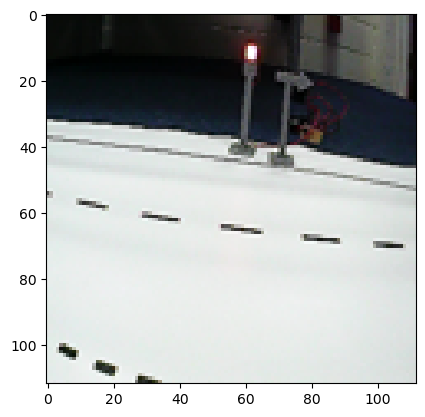

In [4]:
first_image = preprocess_image(f'{image_id}.png')
plt.imshow(first_image)

In [5]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="../ToFang_tflite/Den121_112.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#### Create prediction

In [6]:
def prediction_function(input_array):
    # LIME tries to send batches of 10 we only want 1 per prediction as per tflite requirements

    predictions = []
    for image in input_array:
        input_data = np.expand_dims(image, axis=0)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[target_idx]['index'])
        # Ensure output_data is wrapped as a 2D array
        predictions.append([output_data[0]][0])  # Wrap the scalar output in a list to maintain 2D structure

    return np.array(predictions)  # This should be 2D now

#### Use LIME to explain prediction

Red indicates region of image that decreases prediction 
Green is increasing prediction

In [7]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(first_image, prediction_function, hide_color=0, num_samples=100)

100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


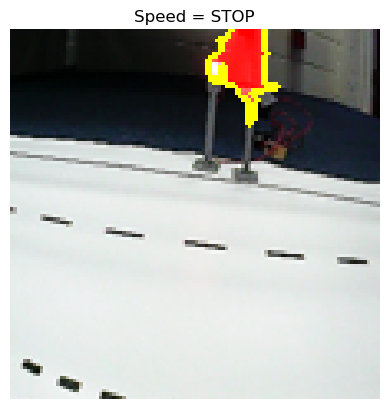

In [13]:
# amount of superpixels taken into account
num_features = 1

temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=num_features, hide_rest=False)
boundary_marked_image = mark_boundaries(temp, mask)
plt.imshow(boundary_marked_image)
plt.axis('off')
pred = round(prediction_function([first_image])[0][0], 3)
if desired_target == 'Speed':
    if pred < 0.6:
        tit = 'STOP'
    else:
        tit = 'GO'
else:
    tit = pred
plt.title(f'{desired_target} = {tit}')
plt.show()
